In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.linalg import inv
import matplotlib.pyplot as plt
import copy as cp
np.random.seed(14)

# Single specie without magnetic noise simulation

In this simulation we assume there is no magnetic noise and no effective magnetic field of the alkali spin. Then, the phase of the Xenon with respect to the drive is given by

\begin{align}
    \phi_{129} &= -\frac{\gamma^{129}_{Xe}B_0}{\Gamma_2^{129}}-\frac{\gamma^{129}_{Xe}B_{noise}}{\Gamma_2^{129}}-\frac{\omega_r}{\Gamma_2^{129}}+\frac{\omega^{129}_{rf}}{\Gamma_2^{129}}
\end{align}


In [85]:
def gaussian(x, mu, sig):
    return (1 / sig / np.sqrt(2 * np.pi)) * np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

def sigmoid(x, w, tau):
    return 1 / (1 + np.exp(-w * (x - tau)))

def smooth(y, box_pts=10):
    box = np.ones(box_pts) / box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth


In [3]:
# symbols
pi_c = chr(960)
phi_c = chr(966)
omega_c = chr(969)
big_omega_c = chr(937)


# physical units and constants
g129 = -74.4069*1e6       # rad  s^-1 T^-1 http://www.acadiau.ca/~bellis/resources/nmr/isotopes.html
g131 = 22.0564*1e6        # rad  s^-1 T^-1 http://www.acadiau.ca/~bellis/resources/nmr/isotopes.html
G2T = 1e-4
T2G = 1e4
D2R = np.pi / 180         # degrees to radians conversion. i.e. 90 deg * D2R = 1.57 [rad]
R2D = 180 / np.pi         # radians to degrees conversion. i.e. 2pi * R2D = 360 [deg]


In [73]:
class Xenon:
    def __init__(self, gamma, t1, t2, K0=np.array([0.05, 0.03, 0.95]), name='129'):

        self.name = name
        # Physical parameters
        self.gamma = gamma      # The xenon gyromagnetic ration   [rad  s^-1 T^-1] 

        # Decays
        self.t1 = t1            # T1 of xenon                     [s]
        self.t2 = t2            # T2 of xenon                     [s]
        self.gamma1 = 1. / t1   #                                 [s^-1]
        self.gamma2 = 1. / t2   #                                 [s^-1]

        # Spin polarization
        self.K0 = K0
        self.Kt = K0
        self.Ksteady = None
        self.Rse = np.array([0, 0, 0])

        # Bloch matrix
        self.M = np.zeros((3, 3))

        # boolean params
        self.drive = True

    def set_spin_exchange_amp(self, rse):
        """Set spin exchange pumping"""
        self.Rse = rse

    def set_bloch_matrix(self, environment):
        """Constructing the Bloch matrix of the dynamics"""
        M = np.array(
            [
              [-self.gamma2 , 0              , 0             ],
              [0            , -self.gamma2   , 0             ],
              [0            , 0              , -self.gamma1  ] 
              ]
        )
        M12 = self.gamma * (environment.B0 + environment.Bnoise) + environment.wr
        if self.drive:
            M[0, 2] = -environment.Ad_y / 2.
            M[1, 2] = environment.Ad_x / 2.
            M[2, 0] = environment.Ad_y / 2.
            M[2, 1] = -environment.Ad_x / 2.
            M12 = M12  - environment.wd_x - environment.wd_y

        M[0, 1] = M12
        M[1, 0] = -M12
        self.M = M

    def bloch_equations(self, K, t):
        """Bloch dynamics model"""
        dK_dt = np.matmul(self.M, K) + self.Rse
        return dK_dt

    def solve_dynamics(self, ts):
        Kt = self.K0
        Kt = odeint(self.bloch_equations, Kt, ts)
        self.Kt = Kt[-1, :]
        return Kt

    def solve_steady_state(self):
        self.Ksteady = -inv(self.M) @ self.Rse

    def display_params(self):
        print('===================================================================')
        print(f'| Xenon {self.name}:')
        print(f'| ----------')
        print(f'| gyromagnetic ratio:     {self.gamma}')
        print(f'| T1:                     {self.t1}')
        print(f'| T2:                     {self.t2}')
        print(f'| K0:                     {self.K0}')
        print(f'| Kt:                     {self.Kt}')
        print(f'| K steady:               {self.Ksteady}')
        print('===================================================================')



In [74]:
class Environment:
    def __init__(self, name='Xenon129 Environment'):
        self.name = name
        self.B0 = 0.          # DC z magnetic field             [Tesla]
        self.Bnoise = 0.      # z magnetic field noise          [Tesla]
        
        # System parameters
        self.wd_x = 0.        # x drive frequency               [rad  s^-1]
        self.Ad_x = 0.        # x drive amplitude               [s^-1]
        self.wd_y = 0.        # y drive frequency               [rad  s^-1]
        self.Ad_y = 0.        # y drive amplitude               [s^-1]
        
        # world rotation 
        self.wr = 0.         # world rotation around z axis    [rad  s^1]
        
    def set_state(self, wr=0, B0=0, Bnoise=0, wd_x=0, Ad_x=0, wd_y=0, Ad_y=0):
        self.wr = wr
        self.B0 = B0
        self.Bnoise = Bnoise
        self.wd_x = wd_x
        self.Ad_x = Ad_x
        self.wd_y = wd_y
        self.Ad_y = Ad_y

    def display_params(self):
        print('===================================================================')
        print(f'| {self.name}:')
        print(f'| ----------')
        print(f'| B0:                     {self.B0}')
        print(f'| B_noise:                {self.Bnoise}')
        print(f'| {omega_c}d_x:                   {self.wd_x}')
        print(f'| {big_omega_c}d_x:                   {self.Ad_x}')
        print(f'| {omega_c}d_y:                   {self.wd_y}')
        print(f'| {big_omega_c}d_y:                   {self.Ad_y}')
        print(f'| {big_omega_c}r:                     {self.wr}')
        print('===================================================================')

| Xenon 129:
| ----------
| gyromagnetic ratio:     -74406900.0
| T1:                     30
| T2:                     8
| K0:                     [-0.0259  0.02    0.3   ]
| Kt:                     [0.05 0.03 0.95]
| K steady:               None
| Xenon129 Environment:
| ----------
| B0:                     0.0001
| B_noise:                6.262934747501274e-13
| ωd_x:                   0
| Ωd_x:                   0
| ωd_y:                   -7440.6900000000005
| Ωd_y:                   0.12909944487358055
| Ωr:                     1.1160227928062507e-45


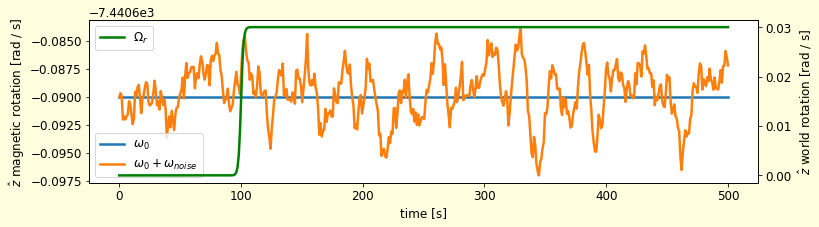

In [100]:
# solver parameters
t_final = 500
dt = 1
steps = int(t_final // dt )
ts1 = np.linspace(0, dt, 2)
ts = np.linspace(0, t_final, steps)

# Xenon parameters
t1 = 30       # s
t2 = 8        # s
Rse = np.array([0, 0, 0.1]) * t1       # |K| / s
Kt = np.zeros((steps, 3))
Ks = np.zeros((steps, 3))

# Environmemnt parameters
B0 = 1 * G2T * np.ones_like(ts)  # Tesla
Bnoise = 1e-6 * G2T * smooth(np.random.randn(len(ts)))  # Tesla
#wr = 30 * gaussian(ts, 600, 40)    # rad / s     
wr = 0.03 * sigmoid(ts, 1, 100)    # rad / s     
Ad = 2 * np.sqrt((1 / t1) * (1 / t2)) * np.ones_like(ts) # rad / s
wd = g129 * 1 * G2T * np.ones_like(ts)                   # rad / s


# initialize Xenon
Xe129 = Xenon(gamma=g129, t1=t1, t2=t2, name='129')
Xe129.K0 = np.array([-0.0259, 0.02, 0.3])
Xe129.set_spin_exchange_amp(Rse)
Xe129.display_params()

# initialize Environment
env = Environment()
env.set_state(wr=wr[0], B0=B0[0], Bnoise=Bnoise[0], Ad_y=Ad[0], wd_y=wd[0])
env.display_params()

# plot world rotation
fig = plt.figure(figsize=(12, 3))
ax = plt.subplot()
ax.plot(ts, Xe129.gamma * B0, label='$\omega_0$')
ax.plot(ts, Xe129.gamma * (B0 + Bnoise), label='$\omega_0 + \omega_{noise}$')
ax.set_ylabel('$\hat{z}$ magnetic rotation [rad / s]')
ax.set_xlabel('time [s]')
ax.legend()
ax1 = ax.twinx()
ax1.plot(ts, wr, label='$\Omega_r$', color='green')
ax1.set_ylabel('$\hat{z}$ world rotation [rad / s]')
ax1.legend()
plt.show()


In [101]:
# run solver and save dynamics
for i, t in enumerate(ts):
    env.set_state(wr=wr[i], B0=B0[i], Bnoise=Bnoise[i], Ad_y=Ad[i], wd_y=wd[i])
    Xe129.set_bloch_matrix(env)
    Xe129.solve_steady_state()
    Ks[i, :] = Xe129.Ksteady
    Kt1 = Xe129.solve_dynamics(ts1)
    Kt[i, :] = Kt1[-1, :]
    Xe129.K0 = Kt1[-1, :]
  


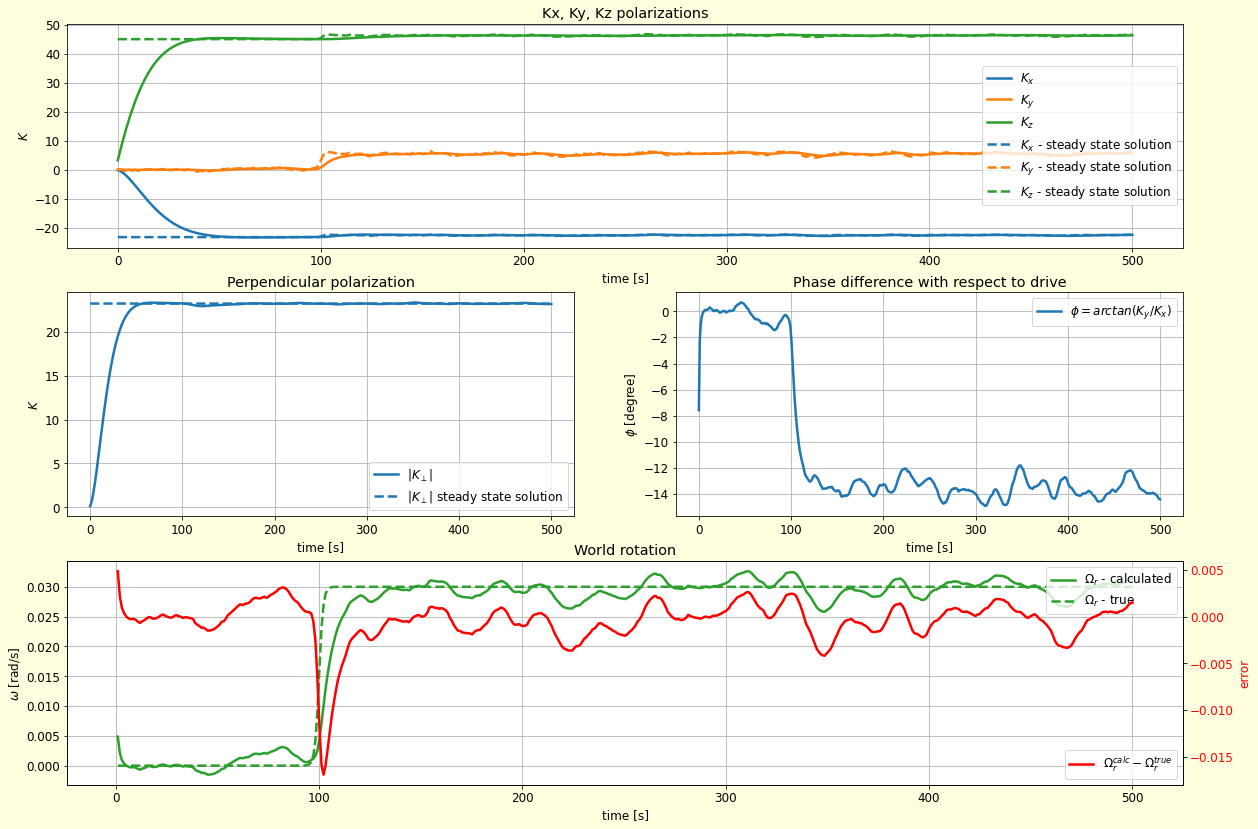

In [102]:
# Plot the spin solution
plt.rcParams.update({'font.size': 12})  # increase the font size
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams["figure.facecolor"] = 'lightyellow'
plt.rcParams["figure.facecolor"] = 'lightyellow'
plt.rcParams["lines.linewidth"] = 2.5

fig = plt.figure(figsize=(20, 14))

ax1 = plt.subplot(3, 2, (1, 2))
ax1.set_title('Kx, Ky, Kz polarizations' )
ax1.set_xlabel("time [s]")
ax1.set_ylabel("$K$")
ax1.plot(ts, Kt[:, 0], label='$K_x$', color='tab:blue')
ax1.plot(ts, Kt[:, 1], label='$K_y$', color='tab:orange')
ax1.plot(ts, Kt[:, 2], label='$K_z$', color='tab:green')
ax1.plot(ts, Ks[:, 0], '--', label='$K_x$ - steady state solution', color='tab:blue')
ax1.plot(ts, Ks[:, 1], '--', label='$K_y$ - steady state solution', color='tab:orange')
ax1.plot(ts, Ks[:, 2], '--',  label='$K_z$ - steady state solution', color='tab:green')
ax1.legend()
ax1.grid(True)


K_perp = np.sqrt(Kt[:, 0] ** 2 + Kt[:, 1] ** 2)
K_perp_steady = np.sqrt(Ks[:, 0] ** 2 + Ks[:, 1] ** 2)
ax2 = plt.subplot(3, 2, 3)
ax2.plot(ts, K_perp, label='$|K_{\perp}|$', color='tab:blue')
ax2.plot(ts, K_perp_steady, '--', label='$|K_{\perp}|$ steady state solution', color='tab:blue')
ax2.set_xlabel("time [s]")
ax2.set_ylabel("$K$")
ax2.grid(True)
ax2.legend()
ax2.set_title('Perpendicular polarization')

phi = np.arctan(Kt[:, 1] / Kt[:, 0])
ax3 = plt.subplot(3, 2, 4)
ax3.plot(ts, phi * R2D, label='$\phi = arctan(K_y/K_x)$')
ax3.set_xlabel("time [s]")
ax3.set_ylabel("$\phi$ [degree]")
ax3.grid(True)
ax3.legend()
ax3.set_title('Phase difference with respect to drive')

ti = 0
world_rotation = -phi * Xe129.gamma2 + Xe129.gamma * B0 - env.wd_y
ax4 = plt.subplot(3, 2, (5, 6))
ax4.plot(ts[ts > ti], world_rotation[ts > ti], label='$\Omega_r$ - calculated', color='tab:green')
ax4.plot(ts[ts > ti], wr[ts > ti], '--', label='$\Omega_r$ - true', color='tab:green')
ax4.set_xlabel("time [s]")
ax4.set_ylabel("$\omega$ [rad/s]")
ax4.grid(True)
ax4.legend(loc='upper right')
ax4.set_title('World rotation')
ax5 = ax4.twinx()
ax5.plot(ts[ts > ti], world_rotation[ts > ti] - wr[ts > ti] ,label='$\Omega_r^{calc} - \Omega_r^{true}$', color='red')
ax5.legend(loc='lower right')
ax5.set_ylabel('error', color='red')
ax5.tick_params(axis='y', labelcolor='red')

plt.tight_layout
plt.show()

In [26]:
t_final = 500
dt = 1
steps = int(t_final // dt )
ts1 = np.linspace(0, dt, 2)
ts = np.linspace(0, t_final, steps)
wd_amplitude = np.array([1e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1, 1., 5., 10. ,100, 1000])
wd_measurements = np.zeros_like(wd_amplitude)
errors = np.zeros_like(wd_amplitude)


for j in range(len(wd_amplitude)):
    t1 = 30       # s
    t2 = 8        # s
    Rse = np.array([0, 0, 0.1]) * t1       # |K| / s
    B0 = 1 * G2T  * np.ones(steps)  # Tesla
    #wr = 30 * gaussian(ts, 600, 40)    # rad / s     
    wr = wd_amplitude[j] * sigmoid(ts, 1, 100)    # rad / s     
    Ad = 2 * np.sqrt((1 / t1) * (1 / t2)) * np.ones(steps) # 1 / s
    wd = g129 * 1 * G2T * np.ones(steps)                   # rad / s
    Kt = np.zeros((steps, 3))
    Ks = np.zeros((steps, 3))


    Xe129 = Xenon(gamma=g129, t1=t1, t2=t2, name='129')
    Xe129.K0 = np.array([-0.0259, 0.02, 0.3])
    Xe129.set_spin_exchange_amp(Rse)

    for i in range(steps):
        Xe129.set_z_bias_field(B0[i])
        Xe129.set_y_drive_field(Ad[i], wd[i])
        Xe129.set_bloch_matrix(B0[i], wr[i])
        Xe129.solve_steady_state()
        Ks[i, :] = Xe129.Ksteady
        Kt1 = Xe129.solve_dynamics(ts1)
        Kt[i, :] = Kt1[-1, :]
        Xe129.K0 = Kt1[-1, :]

    phi = np.arctan(Kt[:, 1] / Kt[:, 0])
    world_rotation = -phi * Xe129.gamma2 + Xe129.gamma * B0 - Xe129.wd_y
    wd_measurements[j] = world_rotation[-1]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


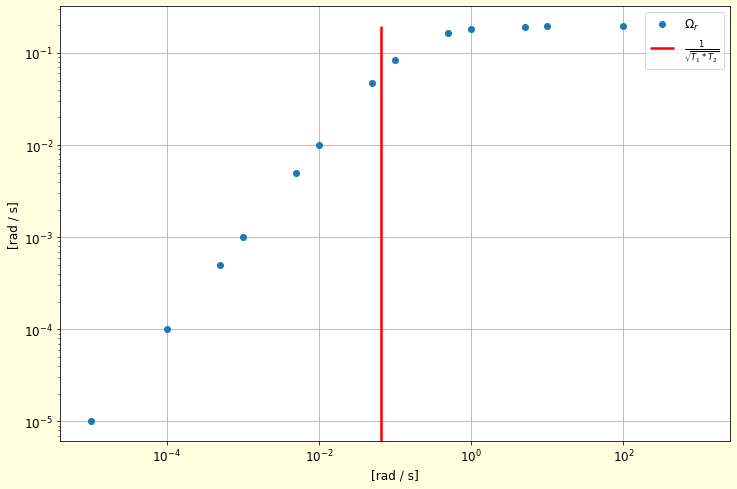

In [27]:
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot()
ax.loglog(wd_amplitude, wd_measurements, 'o', label='$\Omega_r$')
ax.set_ylabel('[rad / s]')
ax.set_xlabel('[rad / s]')
ax.vlines(1 / np.sqrt(t1 * t2), ymin=np.min(wd_measurements), ymax=np.max(wd_measurements), 
          color='red', label=r'$\frac{1}{\sqrt{T_1 * T_2}}$')
ax.grid(True)
ax.legend()
plt.tight_layout
plt.show()